In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)
pd.set_option('display.precision', 3)
pd.option_context('display.max_rows', 50)

import prepare
import explore
import model

random_state = 42

# Acquisition

This data was obtained from the City of Austin's open data portal at data.austintexas.gov. The data is published by the city's Animal Services department and updated on an hourly basis. The data available for this analysis represents all animals taken into the shelter from 10/01/2013 - 03/04/2022.

AAC publishes two separate dataset: "Intakes" and "Outcomes". These datasets were combined to perform this analysis.

From AAC: 
        
        "Intakes represent the status of animals as they arrive at the Animal Center. All animals receive a unique Animal ID during intake."

        "Outcomes represent the status of animals as they leave the Animal Center... Annually over 90% of animals entering the center, are adopted, transferred to rescue or returned to their owners. The Outcomes data set reflects that Austin, TX. is the largest "No Kill" city in the country.

Here, I acquire cached versions of the dataset from my working directory.

In [2]:
# read CSV's into pandas from the local directory
intakes = pd.read_csv('aac_intakes_20220304.csv')
outcomes = pd.read_csv('aac_outcomes_20220304.csv')

# Preparation

I cleaned and prepped the data by creating a function that:

- renamed columns for convenience and legibility
- dropped outcomes that didn't have a corresponding intake, and vis-versa
- converted the datetime columns to pandas datetime types
- added information about how many times the animal had been seen previously at the shelter
- added a unique identifier for each time the animal had been seen at the shelter (stay_id)
- joined the intakes and outcomes dataframes into one dataframe using the 'stay_id' identifier
- dropped variables (except for outcome type) from the original 'outcomes' dataframe, since - by definition - they cannot be drivers of the outcome type. 
- extracted the month from the datetime_intake column to represent the time of year the animal was brought into the shelter
- split the sex_upon_intake column into fixed = True/False and sex = male/female, then dropped the original sex_upon_intake column
- split the original breed column into 'breed_mixed', 'breed_1, and - if there were multiple breeds listed, 'breed_2' and 'breed_3', then dropped the original breed column
- split the color description into multiple columns (color_1, color_2, color_3) when there was more than one color listed, then drop the original color column
- convert the age column from a string into pandas timedelta (number of days)
- create a boolean column 'found_in_austin' based on whether the string value for found_location includes 'Austin (TX)' 
- create a boolean column 'found_in_travis' based on whether the string value for found_location includes 'Travis (TX)'
- create a boolean column 'found_outside_jurisdiction' based on whether found location string value includes 'Outside Jurisdiction'
- create a boolean column 'is_pitbull' based on whether 'breed_1' includes 'Pit Bull'
- create a boolean column 'is_black' based on whether 'color_1' includes 'Black'
- create a column 'akc_breed_group' that uses a dictionary to map each unique value found in the breed_1 column to that breed's group as defined by the American Kennel Club
- drops columns not used for modeling in this analysis
- filters rows to focus on only the most common outcome types: 'Adoption' and 'Transfer'

Then used an additional function to filter the dataset for only the dogs (using animal_type == 'Dog')

Missing values: There were no missing values in the original dataset, though my feature engineering process did create some columns that contained significant numbers of missing values. These columns were ultimately dropped and not used in this analysis. 

In [3]:
# call the functions from the prepare module that 
# perform the steps listed above
df = prepare.aac_prep(intakes, outcomes)
df = prepare.aac_get_dogs(df)

In [4]:
# identify the target column and the positive condition label
target = 'outcome_type'
positive = 'Adoption'

### Split the Data

In [5]:
# call the function from the prepare module that splits data into 3 samples
train, validate, test = prepare.train_validate_test_split(df)

train	 n = 29963
validate n = 12842
test	 n = 10702


# Exploration

### Exploration - Initial Questions
(for the statistical significance testing of the findings in this section, please visit the explore_notebook.ipynb)

#### Are pit bulls adopted at lower rates than other dogs?

It is a common understanding that pit bull-type dogs are less desirable as pets than other dogs and are adopted from shelters at lower rates. Let's see if this holds true in our data set

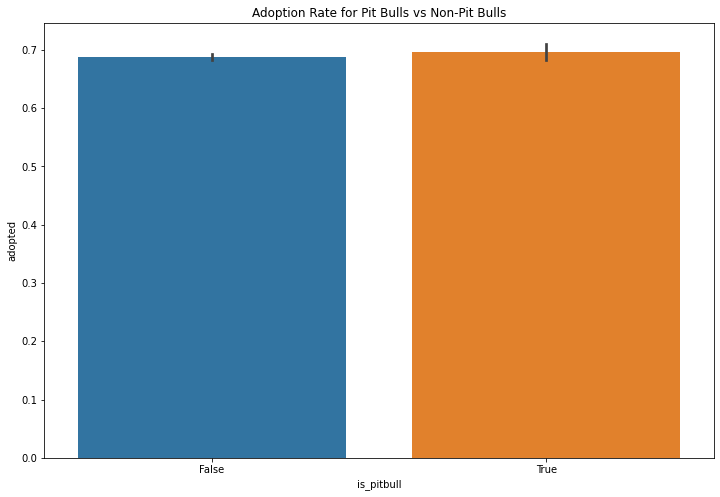

In [6]:
# create a seaborn barplot of adoption rates by is_pitbull
explore.plot_pitbulls(train)

It seems that pitbulls are actually adopted at a similar - perhaps even slightly higher - rate than other dogs in Austin. 

#### Are black dogs adopted at lower rates than other dogs?

It is a common understanding that black dogs are also adopted from shelters at lower rates than other dogs. Does this hold true in Austin?

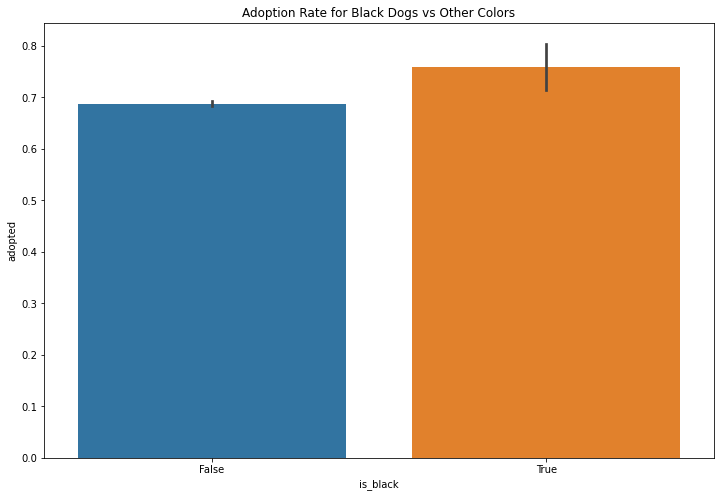

In [7]:
# create a seaborn barplot of adoption rate by is_black
explore.plot_black_dogs(train)

Again, it seems that the common understanding may be false, as black dogs appear to be adopted at similar - and perhaps higher - rates than other dogs in Austin.

#### What differences exist in adoption rates among the AKC breed groups¶


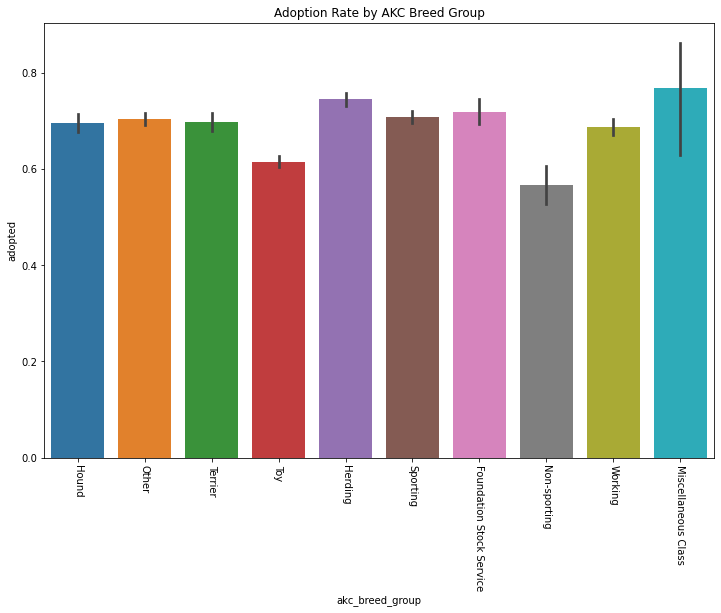

In [8]:
# create a seaborn barplot of adoption rate by akc_breed_group
explore.plot_breed_groups(train)

Adoption rates appear relatively similar among the groups, with exceptions of the Toy Group and the Non-Sporting group, as these appear to be significantly lower. Are these differences significant?

#### How does intake condition affect adoption rate?¶


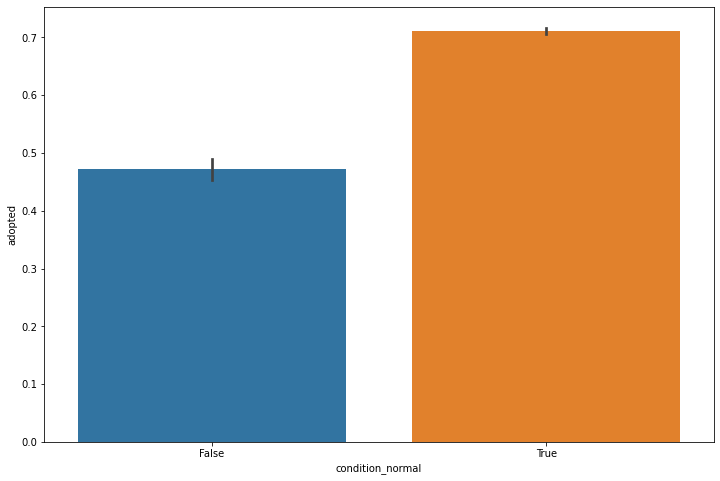

In [9]:
# create a seaborn barplot of adoption rate by intake condition normal
explore.plot_normal_condition(train)

Normal condition dogs appear to be a adopted at much higher rates than other dogs, as might be expected

### Exploration: Summary

The exploration above shows that there may be some public misunderstanding about which dogs are desirable to adopt from shelters, at least in Austin, TX. They also show that breed and color may be less useful as predictors than might be expected, since adoption rates appear to be similar among the categories we examined. 

This doesn't mean that we will leave these features out of our modeling though, since we will use Recursive Feature Engineering algorithms to automatically select which features (out of nearly all available features) have the most predictive utility. 

# Modeling

In this section, I used all the features that were created or maintained in the preparation section to feed into Recursive Feature Engineering algorithms and then created Decision Tree, Random Forest, and Logistic Regression algorithms using the selected sets of features and varying hyperparameters. 

I created 264 unique models that varied the number of features selected and the values for the appropriate hyperparameters for that model type. 

I stored information about each of the models' performance and parameters as dataframes, and cached those dataframes as CSV's on my local drive. 

To prevent redoing the time-consuming computation required to create those models, I will use the cached data to display information about model performance below. 

(to recreate the modeling that produced the CSV's, please see model.py and/or model_notebook.ipynb)

In [10]:
# read model_info and model_results CSV's into pandas from the local directory
model_info = pd.read_csv('model_info_1.csv').drop(columns='Unnamed: 0')
model_results = pd.read_csv('model_results_1.csv').drop(columns='Unnamed: 0')

First, I created baseline predictions using the most common outcome type ('Adoption') and evaluated the performance of those predictions:

In [11]:
# display baseline results
model.display_model_results(model_results[model_results.model_number == 'baseline'])

model_number             baseline
metric_type sample_type          
accuracy    train           0.688
            validate        0.688
f1_score    train           0.815
            validate        0.815
precision   train           0.688
            validate        0.688
recall      train           1.000
            validate        1.000

I then looked at the models which peformed with the highest accuracy on the validate set.

(without any specific goals in mind as to the use case for this model, the accuracy metric provides a balanced look at the performance of the model, and is a reasonable choice since the outcomes are not weighted too far to one category or the other).

The top 3 models are shown below:

In [12]:
# display results for the top 3 models
model.display_model_results(model.get_best_model_results(model_results))

model_number               178    186    187
metric_type sample_type                     
accuracy    train        0.724  0.720  0.725
            validate     0.713  0.713  0.713
f1_score    train        0.830  0.828  0.830
            validate     0.823  0.824  0.823
precision   train        0.721  0.717  0.722
            validate     0.715  0.714  0.715
recall      train        0.977  0.978  0.977
            validate     0.970  0.974  0.969

In [13]:
# display info about the top 3 models
model_info[model_info.model_number.isin(['178', '186', '187'])].drop(columns=['c_value', 'model_number'])

,model_type,features,max_depth,min_samples_leaf
178,random forest,"['enc_fixed_unknown', 'enc_breed_mixed_True', ...",10.0,2.0
186,random forest,"['enc_fixed_unknown', 'enc_breed_mixed_True', ...",9.0,2.0
187,random forest,"['enc_fixed_unknown', 'enc_breed_mixed_True', ...",10.0,2.0


The three models perform with nearly the same level of accuracy on the validate set. However, Model # 178 is a slightly simpler model, using 11 features instead of the 12 used in the other two.

For this reason, I selected model # 178 to move forward to the final test phase.

### Modeling - Final Test

Here, I evaluate model # 178's accuracy on the test sample, simulating how it might perform if used on future data in the real-world.

In [14]:
# add encoded columns
df = prepare.aac_prep_for_modeling(df)
# then re-split for modeling (random state inside the function makes the split repeatable)
train, validate, test = prepare.train_validate_test_split(df)
# then add scaled columns
train, validate, test = prepare.scale_aac(train, validate, test)

train	 n = 29963
validate n = 12842
test	 n = 10702


In [15]:
# recreate model 178 and return info about its performance
model.test_model_178(train, test, target, positive)

,model_number,sample_type,metric_type,score
0,178.0,test,accuracy,0.706
1,178.0,test,precision,0.708
2,178.0,test,recall,0.970
3,178.0,test,f1_score,0.818


#### Model Performance

The model peforms with 70.6% accuracy on the test sample, which is a 1.8 point increase over our baseline accuracy of 68.8%.

### Key Findings

The following features were automatically selected by the RFE algorithms as the most important features in our selected model:
- whether or not the dog's spayed/neutered status was unknown
- whether the breed was mixed
- whether the intake type was a Public Assist
- whether the intake condition was Normal
- whether the intake condition was Sick
- whether the intake month was September
- whether the dog's sex was unknown
- whether the dog's primary breed was contained in the top 10 most common breeds
- whether the dog was in the Toy breed group
- whether the dog was found inside Austin city limits
- the age of the dog

Some additional exploration could tell us whether these factors increased or decreased the odds of the dog's being adopted. 

### Recommendations/Next Steps

Since I did not find significant predictive capability in my analysis, I don't have any specific recommendations for AAC at this time. However, there is a lot of interesting potential in this dataset. Some things I would like to do in the future include: 

1. Start by predicting whether a dog would be returned to it's owner, using Outcome Type == 'Return to Owner' as a target. From there, we could do some additional analysis to predict which dogs would be adopted. This might be a more useful prediction. 

2. Acquiring some domain knowledge about which animals are chosen for transfer and why could steer future analysis in more useful directions. I'd like to send an email inquiry to AAC officials to learn more about their processes. 

3. There is much more granular data available about the location where the animal was found that was not used in this analysis. I would like to use the Google Maps API to obtain more precise location info, then create additional features for modeling using zip codes, neighborhoods, or clustering algorithms. I suspect location information would prove valuable for predicting whether a dog would be returned to it's owner. 

4. Additional breed groupings could also prove useful for predictions. I would like to engineer additional features using varying categorizations such as whether the dog is considered to be:
    -  family friendly
    -   intelligent
    -   loyal
    -   etc
    
    The AKC maintains some lists like this that could be used to match individual breeds to a category. 

5. I would lso like to create more robust and interesting visualizations that would appeal to a public audience. Some of these might include: 
    - heat map of found_location
    - information about which breeds/breed categories are most common
    - which breeds/breed categories are adopted most frequently
    - which colors/color categories are most common/adopted most frequently
    - etc.


